In [1]:
!sudo apt-get update
!sudo apt-get install -y swig g++ python3-dev
!pip install gymnasium[box2d] torch


Reading package lists... Done
E: Could not get lock /var/lib/apt/lists/lock. It is held by process 5237 (apt-get)
N: Be aware that removing the lock file is not a solution and may break your system.
E: Unable to lock directory /var/lib/apt/lists/
E: Could not get lock /var/lib/dpkg/lock-frontend. It is held by process 6209 (apt-get)
N: Be aware that removing the lock file is not a solution and may break your system.
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), is another process using it?


Discretized action space size: 81
Starting training on BipedalWalker-v3 with Q-Learning (State/Action Discretized)...
!!! WARNING: This is expected to perform poorly or fail due to state space size !!!
Episode 50/500 | Avg Reward (Last 50): -119.58 | Q-Table Size: 3251 | Epsilon: 0.951
Episode 100/500 | Avg Reward (Last 50): -114.91 | Q-Table Size: 4569 | Epsilon: 0.905
Episode 150/500 | Avg Reward (Last 50): -113.25 | Q-Table Size: 5411 | Epsilon: 0.861
Episode 200/500 | Avg Reward (Last 50): -112.89 | Q-Table Size: 5997 | Epsilon: 0.819
Episode 250/500 | Avg Reward (Last 50): -108.94 | Q-Table Size: 6482 | Epsilon: 0.779
Episode 300/500 | Avg Reward (Last 50): -109.65 | Q-Table Size: 6876 | Epsilon: 0.741
Episode 350/500 | Avg Reward (Last 50): -108.68 | Q-Table Size: 7272 | Epsilon: 0.705
Episode 400/500 | Avg Reward (Last 50): -106.73 | Q-Table Size: 7582 | Epsilon: 0.670
Episode 450/500 | Avg Reward (Last 50): -111.97 | Q-Table Size: 7966 | Epsilon: 0.637
Episode 500/500 | Avg Rew

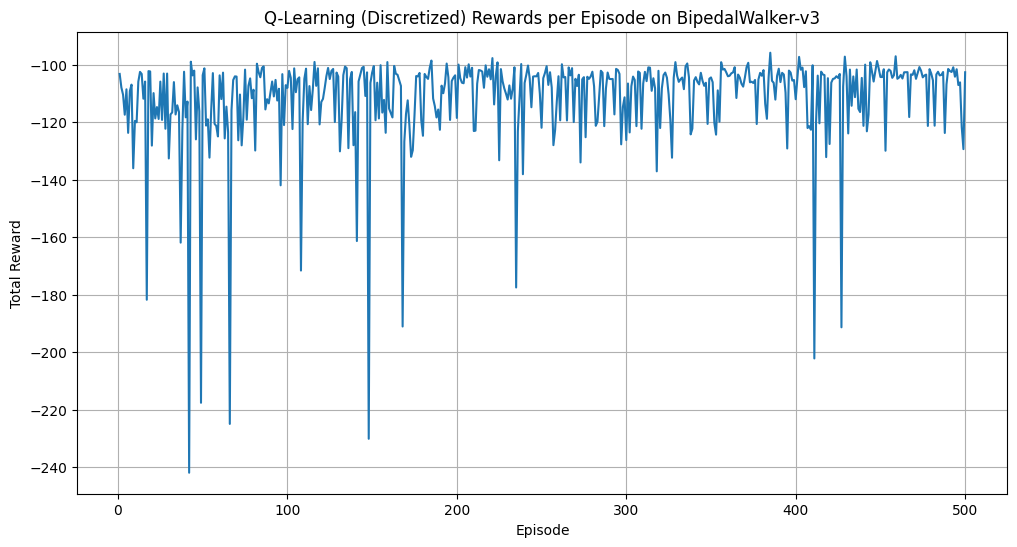

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import itertools
from collections import defaultdict
import math

environment_name = "BipedalWalker-v3"
learning_rate = 0.1
gamma = 0.99
num_episodes = 500
max_steps_per_episode = 1600
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay_rate = 0.999

num_state_bins = 4
num_action_bins = 3

log_interval = 50
save_directory = "./qlearning_results"
random_seed = 42

os.makedirs(save_directory, exist_ok=True)

np.random.seed(random_seed)
random.seed(random_seed)

environment = gym.make(environment_name, render_mode=None)
state_dimension = environment.observation_space.shape[0]
continuous_action_dimension = environment.action_space.shape[0]
action_lower_bound = environment.action_space.low
action_upper_bound = environment.action_space.high
state_lower_bound = environment.observation_space.low
state_upper_bound = environment.observation_space.high

state_lower_bound[state_lower_bound == -np.inf] = -5.0
state_upper_bound[state_upper_bound == np.inf] = 5.0

def create_discrete_actions(num_bins, action_dimension, lower_bound, upper_bound):
    dimension_bins = []
    for i in range(action_dimension):
        dimension_bins.append(np.linspace(lower_bound[i], upper_bound[i], num_bins))
    discrete_actions_continuous_values = list(itertools.product(*dimension_bins))
    return [np.array(action) for action in discrete_actions_continuous_values]

discrete_actions_list = create_discrete_actions(num_action_bins, continuous_action_dimension, action_lower_bound, action_upper_bound)
num_discrete_actions = len(discrete_actions_list)
print(f"Discretized action space size: {num_discrete_actions}")

def discrete_index_to_continuous_action(action_index):
    return discrete_actions_list[action_index]

def discretize_state(continuous_state, num_bins, state_lower_bound, state_upper_bound, state_dimension):
    discrete_state_list = []
    for i in range(state_dimension):
        clipped_value = np.clip(continuous_state[i], state_lower_bound[i], state_upper_bound[i])
        bin_width = (state_upper_bound[i] - state_lower_bound[i]) / num_bins
        if bin_width > 0:
            bin_index = min(int((clipped_value - state_lower_bound[i]) / bin_width), num_bins - 1)
        else:
            bin_index = 0
        discrete_state_list.append(bin_index)
    return tuple(discrete_state_list)

q_value_table = defaultdict(lambda: np.zeros(num_discrete_actions))

current_epsilon = epsilon_start

def select_action(current_discrete_state):
    if random.random() < current_epsilon:
        return random.randrange(num_discrete_actions)
    else:
        return np.argmax(q_value_table[current_discrete_state])

def update_q_value_table(current_discrete_state, action_index, reward_value, next_discrete_state, is_terminal):
    current_q_value = q_value_table[current_discrete_state][action_index]
    max_next_q_value = np.max(q_value_table[next_discrete_state]) if not is_terminal else 0
    updated_q_value = current_q_value + learning_rate * (reward_value + gamma * max_next_q_value - current_q_value)
    q_value_table[current_discrete_state][action_index] = updated_q_value

def decay_epsilon():
    global current_epsilon
    current_epsilon = max(epsilon_end, current_epsilon * epsilon_decay_rate)

episode_reward_history = []
print(f"Starting training on {environment_name} with Q-Learning (State/Action Discretized)...")
print("!!! WARNING: This is expected to perform poorly or fail due to state space size !!!")

for episode_number in range(1, num_episodes + 1):
    current_continuous_state, _ = environment.reset(seed=random_seed + episode_number)
    current_discrete_state = discretize_state(current_continuous_state, num_state_bins, state_lower_bound, state_upper_bound, state_dimension)
    current_episode_reward = 0

    for step_number in range(max_steps_per_episode):
        selected_action_index = select_action(current_discrete_state)
        selected_continuous_action = discrete_index_to_continuous_action(selected_action_index)

        next_continuous_state, step_reward, is_terminated, is_truncated, _ = environment.step(selected_continuous_action)
        is_terminal = is_terminated or is_truncated
        next_discrete_state = discretize_state(next_continuous_state, num_state_bins, state_lower_bound, state_upper_bound, state_dimension)

        update_q_value_table(current_discrete_state, selected_action_index, step_reward, next_discrete_state, is_terminal)

        current_discrete_state = next_discrete_state
        current_episode_reward += step_reward

        if is_terminal:
            break

    decay_epsilon()
    episode_reward_history.append(current_episode_reward)

    if episode_number % log_interval == 0:
        average_reward = np.mean(episode_reward_history[-log_interval:])
        q_value_table_size = len(q_value_table)
        print(f"Episode {episode_number}/{num_episodes} | Avg Reward (Last {log_interval}): {average_reward:.2f} | Q-Table Size: {q_value_table_size} | Epsilon: {current_epsilon:.3f}")
        if q_value_table_size > 1_000_000:
            print("WARNING: Q-Table size potentially exceeding manageable limits!")

print("Training finished (or aborted due to impracticality).")

q_value_table_to_save = dict(q_value_table)
q_table_file_path = os.path.join(save_directory, "q_table.npy")
np.save(q_table_file_path, q_value_table_to_save)
print(f"Saved Q-Table to {q_table_file_path}")

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(episode_reward_history) + 1), episode_reward_history)
plt.title(f"Q-Learning (Discretized) Rewards per Episode on {environment_name}")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plot_file_path = os.path.join(save_directory, "qlearning_rewards_plot.png")
plt.savefig(plot_file_path)
print(f"Saved rewards plot to {plot_file_path}")

print("\nEvaluating trained agent (using learned Q-Table)...")
try:
    loaded_q_table_dict = np.load(q_table_file_path, allow_pickle=True).item()
    evaluation_q_table = defaultdict(lambda: np.zeros(num_discrete_actions), loaded_q_table_dict)
except Exception as exception:
    print(f"Could not load Q-table: {exception}. Evaluation may fail.")
    evaluation_q_table = defaultdict(lambda: np.zeros(num_discrete_actions))

evaluation_episode_rewards = []
evaluation_environment = gym.make(environment_name)

for eval_episode_index in range(10):
    current_continuous_state_eval, _ = evaluation_environment.reset(seed=random_seed + num_episodes + eval_episode_index)
    current_evaluation_reward = 0
    is_terminated_eval, is_truncated_eval = False, False
    eval_step_number = 0
    while not (is_terminated_eval or is_truncated_eval) and eval_step_number < max_steps_per_episode:
        current_discrete_state_eval = discretize_state(current_continuous_state_eval, num_state_bins, state_lower_bound, state_upper_bound, state_dimension)
        selected_action_index_eval = np.argmax(evaluation_q_table[current_discrete_state_eval])
        selected_continuous_action_eval = discrete_index_to_continuous_action(selected_action_index_eval)

        next_continuous_state_eval, step_reward_eval, is_terminated_eval, is_truncated_eval, _ = evaluation_environment.step(selected_continuous_action_eval)
        current_evaluation_reward += step_reward_eval
        eval_step_number += 1
    evaluation_episode_rewards.append(current_evaluation_reward)
    print(f"Evaluation Episode {eval_episode_index+1}/10 | Reward: {current_evaluation_reward:.2f}")

evaluation_environment.close()
average_evaluation_reward = np.mean(evaluation_episode_rewards)
print(f"\nAverage Evaluation Reward (10 episodes): {average_evaluation_reward:.2f}")
print(f"(Note: Q-learning evaluation results are likely very poor due to discretization limitations)")

environment.close()